# EDA: Swire Coca - Cola
## Griffin Brown
9/4/24

This file serves as my personal EDA for the IWC Work Orders.

## Data Loading

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
df = pd.read_csv('IWC_Work_Orders_Extract.csv', low_memory=False)

df.head()

,ORDER_ID,PLANT_ID,PRODUCTION_LOCATION,EXECUTION_START_DATE,EXECUTION_FINISH_DATE,ACTUAL_START_TIME,ACTUAL_FINISH_TIME,ACTUAL_WORK_IN_MINUTES,MAINTENANCE_PLAN,MAINTENANCE_ITEM,...,FUNCTIONAL_AREA_NODE_2_MODIFIED,FUNCTIONAL_AREA_NODE_3_MODIFIED,FUNCTIONAL_AREA_NODE_4_MODIFIED,FUNCTIONAL_AREA_NODE_5_MODIFIED,EQUIPMENT_ID,EQUIPMENT_DESC,EQUIP_CAT_DESC,EQUIP_START_UP_DATE,EQUIP_VALID_FROM,EQUIP_VALID_TO
0,705642457,G812,ROMA,2024-05-04,2024-05-12,06:00:00.000,23:04:08.000,390.0,NaN,NaN,...,G812 PRD FILLER_ROTARY_CAN,G812 PRD FILLER_ROTARY_CAN LINE 3,CONVEYOR,FULL CAN CONVEYOR,300126812.0,FULL CAN CONVEYOR (FC41B),Machines,2020-04-22,2020-02-10,9999-12-31
1,704191697,G812,ROMA,2022-09-13,2022-09-13,06:00:00.000,17:17:24.000,420.0,NaN,NaN,...,G812 PRD FILLER_ROTARY_CAN,G812 PRD FILLER_ROTARY_CAN LINE 3,CONVEYOR,FULL CAN CONVEYOR,300126812.0,FULL CAN CONVEYOR (FC41B),Machines,2020-04-22,2020-02-10,9999-12-31
2,704466547,G812,ROMA,2022-12-21,2022-12-21,07:00:00.000,07:00:00.000,30.0,NaN,NaN,...,G812 PRD FILLER_ROTARY_CAN,G812 PRD FILLER_ROTARY_CAN LINE 3,CONVEYOR,FULL CAN CONVEYOR,300126812.0,FULL CAN CONVEYOR (FC41B),Machines,2020-04-22,2020-02-10,9999-12-31
3,703834477,G812,ROMA,2022-07-04,2022-07-04,06:00:00.000,06:00:00.000,60.0,NaN,NaN,...,G812 PRD FILLER_ROTARY_CAN,G812 PRD FILLER_ROTARY_CAN LINE 3,CONVEYOR,FULL CAN CONVEYOR,300126812.0,FULL CAN CONVEYOR (FC41B),Machines,2020-04-22,2020-02-10,9999-12-31
4,704661125,G291,MONZA,2023-03-15,2023-03-15,07:00:00.000,07:00:00.000,120.0,NaN,NaN,...,AIR SYSTEMS,NaN,NaN,NaN,300001088.0,TANK_STL_STOR_AIR,Machines,2017-02-15,2023-12-11,9999-12-31


In [3]:
df.shape

(1427264, 25)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1427264 entries, 0 to 1427263
Data columns (total 25 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   ORDER_ID                         1427264 non-null  int64  
 1   PLANT_ID                         1427264 non-null  object 
 2   PRODUCTION_LOCATION              1427264 non-null  object 
 3   EXECUTION_START_DATE             1427264 non-null  object 
 4   EXECUTION_FINISH_DATE            1427264 non-null  object 
 5   ACTUAL_START_TIME                1427264 non-null  object 
 6   ACTUAL_FINISH_TIME               1427264 non-null  object 
 7   ACTUAL_WORK_IN_MINUTES           1427264 non-null  float64
 8   MAINTENANCE_PLAN                 152594 non-null   object 
 9   MAINTENANCE_ITEM                 152594 non-null   float64
 10  MAINTENANCE_ACTIVITY_TYPE        1427264 non-null  object 
 11  ORDER_DESCRIPTION                291767 non-null  

## Data Cleaning

### Dates

In [5]:
# change valid date columns to datetime
dates = ['EXECUTION_START_DATE', 'EXECUTION_FINISH_DATE', 'EQUIP_START_UP_DATE', 'EQUIP_VALID_FROM', 'EQUIP_VALID_TO']

for col in dates:
    df[col] = pd.to_datetime(df[col], errors='coerce')

### Times

In [6]:
df['ACTUAL_START_TIME'] = pd.to_datetime('1900-01-01 ' + df['ACTUAL_START_TIME'], errors='coerce')
df['ACTUAL_FINISH_TIME'] = pd.to_datetime('1900-01-01 ' + df['ACTUAL_FINISH_TIME'], errors='coerce')

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1427264 entries, 0 to 1427263
Data columns (total 25 columns):
 #   Column                           Non-Null Count    Dtype         
---  ------                           --------------    -----         
 0   ORDER_ID                         1427264 non-null  int64         
 1   PLANT_ID                         1427264 non-null  object        
 2   PRODUCTION_LOCATION              1427264 non-null  object        
 3   EXECUTION_START_DATE             1427264 non-null  datetime64[ns]
 4   EXECUTION_FINISH_DATE            1427264 non-null  datetime64[ns]
 5   ACTUAL_START_TIME                1427264 non-null  datetime64[ns]
 6   ACTUAL_FINISH_TIME               1427264 non-null  datetime64[ns]
 7   ACTUAL_WORK_IN_MINUTES           1427264 non-null  float64       
 8   MAINTENANCE_PLAN                 152594 non-null   object        
 9   MAINTENANCE_ITEM                 152594 non-null   float64       
 10  MAINTENANCE_ACTIVITY_TYPE     

### Basic Stats

In [7]:
df.nunique()

ORDER_ID                           1427244
PLANT_ID                                 6
PRODUCTION_LOCATION                      6
EXECUTION_START_DATE                  2956
EXECUTION_FINISH_DATE                 2956
ACTUAL_START_TIME                    65927
ACTUAL_FINISH_TIME                   61388
ACTUAL_WORK_IN_MINUTES                4801
MAINTENANCE_PLAN                      3308
MAINTENANCE_ITEM                      4021
MAINTENANCE_ACTIVITY_TYPE                2
ORDER_DESCRIPTION                   118925
MAINTENANCE_TYPE_DESCRIPTION             5
FUNCTIONAL_LOC                         667
FUNCTIONAL_AREA_NODE_1_MODIFIED          7
FUNCTIONAL_AREA_NODE_2_MODIFIED         67
FUNCTIONAL_AREA_NODE_3_MODIFIED        141
FUNCTIONAL_AREA_NODE_4_MODIFIED         86
FUNCTIONAL_AREA_NODE_5_MODIFIED         36
EQUIPMENT_ID                          2956
EQUIPMENT_DESC                         807
EQUIP_CAT_DESC                           4
EQUIP_START_UP_DATE                     92
EQUIP_VALID

In [8]:
count_by_plan = df.groupby('MAINTENANCE_ACTIVITY_TYPE')['ACTUAL_WORK_IN_MINUTES'].count()

count_by_plan

MAINTENANCE_ACTIVITY_TYPE
Planned       150387
Unplanned    1276877
Name: ACTUAL_WORK_IN_MINUTES, dtype: int64

In [9]:
avg_by_plan = df.groupby('MAINTENANCE_ACTIVITY_TYPE')['ACTUAL_WORK_IN_MINUTES'].mean()

avg_by_plan

MAINTENANCE_ACTIVITY_TYPE
Planned      48.034311
Unplanned    93.410893
Name: ACTUAL_WORK_IN_MINUTES, dtype: float64

## EDA

### Timeframes

In [10]:
min_date = df['EXECUTION_START_DATE'].min()
max_date = df['EXECUTION_FINISH_DATE'].max()

time_diff = max_date - min_date

time_diff_years = round((time_diff.days / 365.25), 2)

print(f'Timeframe:', time_diff_years, 'years')

Timeframe: 11.03 years


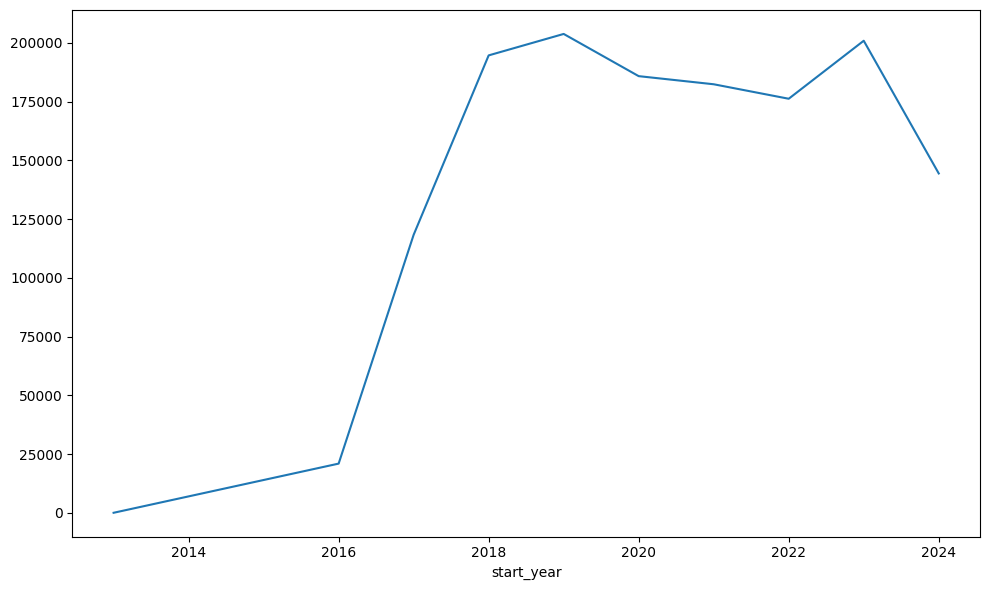

In [11]:
df['start_year'] = df['EXECUTION_START_DATE'].dt.year

count_by_year = df.groupby('start_year').size()

plt.figure(figsize=(10, 6))
count_by_year.plot(kind='line')
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

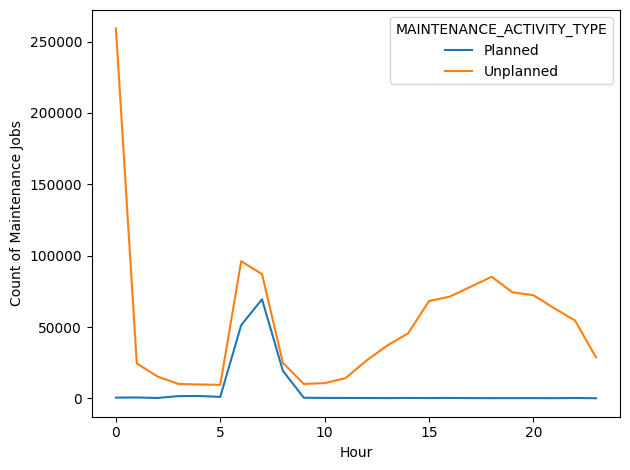

In [12]:
df['hour_start'] = df['ACTUAL_START_TIME'].dt.hour
count_by_hour_type = df.groupby(['hour_start','MAINTENANCE_ACTIVITY_TYPE']).size().unstack()

plt.figure(figsize=(10,6))
count_by_hour_type.plot(kind='line')
plt.ylabel('Count of Maintenance Jobs')
plt.xlabel('Hour')
plt.tight_layout()
plt.show()

### Maintenance Activity Type

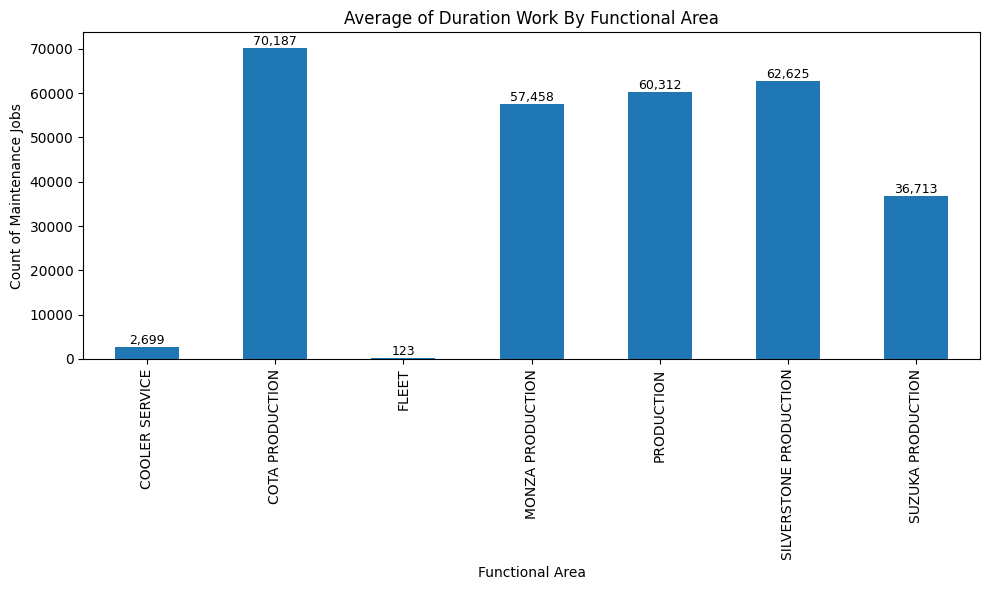

In [13]:
count_by_functional_area = df.groupby('FUNCTIONAL_AREA_NODE_1_MODIFIED')['ACTUAL_WORK_IN_MINUTES'].count()

plt.figure(figsize=(10, 6))
count_by_functional_area.plot(kind='bar')
plt.title('Average of Duration Work By Functional Area')
for i, value in enumerate(count_by_functional_area):
    plt.text(i, value, f'{value:,.0f}', fontsize=9, ha='center', va='bottom')
plt.ylabel('Count of Maintenance Jobs')
plt.xlabel('Functional Area')
plt.tight_layout()
plt.show()

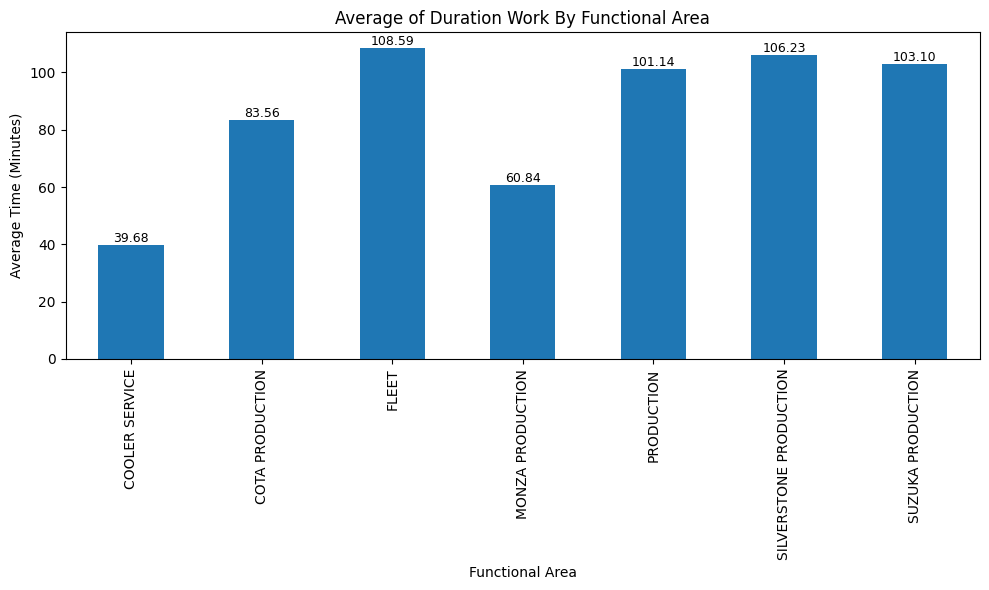

In [14]:
avg_by_functional_area = df.groupby('FUNCTIONAL_AREA_NODE_1_MODIFIED')['ACTUAL_WORK_IN_MINUTES'].mean()

plt.figure(figsize=(10, 6))
avg_by_functional_area.plot(kind='bar')
plt.title('Average of Duration Work By Functional Area')
for i, value in enumerate(avg_by_functional_area):
    plt.text(i, value, f'{value:.2f}', fontsize=9, ha='center', va='bottom')
plt.ylabel('Average Time (Minutes)')
plt.xlabel('Functional Area')
plt.tight_layout()
plt.show()

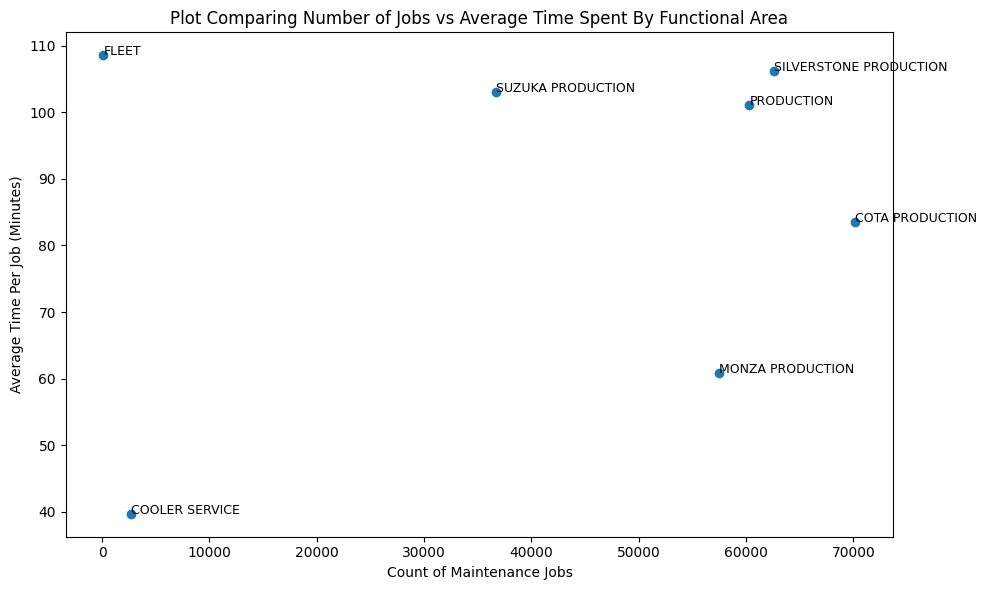

In [15]:
count_x = df['FUNCTIONAL_AREA_NODE_1_MODIFIED'].value_counts()
count_y = df.groupby('FUNCTIONAL_AREA_NODE_1_MODIFIED')['ACTUAL_WORK_IN_MINUTES'].mean()

merged_counts = pd.DataFrame({'occurences': count_x, 'average_time': count_y})

plt.figure(figsize=(10,6))
plt.scatter(merged_counts['occurences'], merged_counts['average_time'])
for i, value in merged_counts.iterrows():
    plt.text(value['occurences'], value['average_time'], str(i), fontsize=9, ha='left')
plt.xlabel('Count of Maintenance Jobs')
plt.ylabel('Average Time Per Job (Minutes)')
plt.title('Plot Comparing Number of Jobs vs Average Time Spent By Functional Area')
plt.tight_layout()
plt.show()